In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo

import psycopg2
from sqlalchemy import create_engine 

import re
from tqdm import tqdm
from datetime import datetime, timedelta

In [6]:
pio.renderers.default = 'pdf'
pyo.init_notebook_mode(connected=True)

In [7]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'

conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

In [9]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

df = pd.read_sql_query('SELECT * FROM data.raw_data', conn)
conn.close()

# Main

In [10]:
df.describe(include='all')

,website,section,url,header,body,date,tags
count,39776,39776,39776,39776,39775,39776,39627
unique,4,201,39766,39172,39755,38616,27762
top,Интерфакс,Новости компаний и новости по акциям,https://ria.ru/20230531/gaz-1875325632.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...",Источник,"29 августа 2023, 13:55",[]
freq,14686,12472,2,34,3,5,2671


> __Conclusions:__ 
> 1. You can notice that we have no gaps in the data 
> 2. You can notice that we have urls that are presented more than once, which hints to us that there are duplicates that we will need to get rid of
> 3. You may notice that we have news with similar headlines, as a result, you will need to understand whether such news are duplicates and decide what to do with them 
> 4. You can notice that we have news with completely repeating texts of short length, which most likely indicates the need to get rid of such 'empty' news

# URL

In [11]:
df[['url']].groupby('url').value_counts().sort_values().tail(11)

url
https://smart-lab.ru/blog/896323.php                  1
https://ria.ru/20230531/mongoliya-1875328673.html     2
https://ria.ru/20230531/gaz-1875325632.html           2
https://ria.ru/20230531/vstrecha-1875349749.html      2
https://ria.ru/20230531/volkswagen-1875349174.html    2
https://ria.ru/20230531/gaz-1875314656.html           2
https://ria.ru/20230531/gaz-1875308876.html           2
https://ria.ru/20230531/peregovory-1875357995.html    2
https://ria.ru/20230531/rosneft-1875372066.html       2
https://ria.ru/20230531/gazprom-1875372984.html       2
https://ria.ru/20230531/nalog-1875319473.html         2
Name: count, dtype: int64

In [12]:
df_new = df.drop_duplicates()

In [13]:
df_new.describe(include='all')

,website,section,url,header,body,date,tags
count,39766,39766,39766,39766,39765,39766,39617
unique,4,201,39766,39172,39755,38616,27762
top,Интерфакс,Новости компаний и новости по акциям,https://www.interfax.ru/russia/879448,"""Газпром"" подает газ через Украину на ГИС ""Суд...",Источник,"06.10.2023, 01:04",[]
freq,14686,12472,1,34,3,5,2671


> __Conclusions:__ Now all our URLs are unique (in addition, we realized that these 10 deleted news were complete duplicates of already submitted news)

# Body

## Let's clean the texts from uninformative parts

### First of all, let’s get rid of external links in texts (in test format) 

In [14]:
patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
]

In [15]:
links = []
ids = []

for i in tqdm(range(df_new.shape[0])):
    if df_new.iloc[i,:].body is not None:
        for pattern in patterns:
            lst_help = re.findall(pattern, df_new.iloc[i,:].body)
            if lst_help:
                links.extend(lst_help)
                ids.append(i)

# print(len(links))
# print(links)

100%|█████████████████████████████████████████████████████████| 39766/39766 [01:01<00:00, 646.86it/s]


Now, after we have made sure that our regex pattern correctly finds external links in texts (at least a significant part of them), we can get rid of them in the texts themselves

In [16]:
def remove_links(text):
    patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
    ]
    
    if text is not None:
        for pattern in patterns:
            text = re.sub(pattern, ' ', text)
    
    return text

vectorized_remove_links = np.vectorize(remove_links)

In [17]:
df_new = df_new.copy()
df_new['body'] = vectorized_remove_links(df_new.body)

### Now let’s go through individual portals in which the same pieces of text are repeated and get rid of them (in our case, these are RIA and Interfax)

In [18]:
def sub_ria(text):
    pattern = r'^.*(?:—|-|–) РИА Новости(?:.|,)'
    return re.sub(pattern, ' ', text, count=1)

vectorized_sub_ria = np.vectorize(sub_ria)

df_new['body'] = vectorized_sub_ria(df_new.body)

In [19]:
def sub_interfax(text):
    pattern = r'^.*INTERFAX.RU'
    return re.sub(pattern, ' ', text, count=1)

vectorized_sub_interfax = np.vectorize(sub_interfax)

df_new['body'] = vectorized_sub_interfax(df_new.body)

## After we have gotten rid of uninformative and unnecessary parts in news texts, we can look at the distribution of text lengths and, as a result, get rid of news with very short (almost no information) texts and news with completely duplicate texts

### First, let's delete short news from all portals

In [20]:
df_new.loc[:, 'body_length'] = df_new['body'].apply(len)

In [22]:
quantile_lst = []
for i in [round(0.01 + 1/100*i, 2) for i in range(10)]:
    length = df_new[["body_length"]].quantile(i)[0]
    quantile_lst.append(length)
    
quantile_lst = [int(i) for i in quantile_lst]

In [24]:
for i, quantile_len in enumerate(quantile_lst):
    print(f'Quantile {(i+1)/100} with length: {quantile_len}')
    print(df_new[df_new['body_length']>quantile_len].sort_values(by='body_length').iloc[0,:].body)
    print('-------------------------------------------------------------------------------------')

Quantile 0.01 with length: 60
«Дагестанская энергосбытовая компания» Отчет МСФО

Источник: 
-------------------------------------------------------------------------------------
Quantile 0.02 with length: 98
25 августа 2023 года - НОВАТЭК - СД решит по дивидендам

Самые быстрые новости у нас!  

Источник: 
-------------------------------------------------------------------------------------
Quantile 0.03 with length: 123
01.06.2023 - «Газпром газораспределение Ростов-на-Дону» - СД решит по дивидендам

Самые быстрые новости у нас!  

Источник: 
-------------------------------------------------------------------------------------
Quantile 0.04 with length: 157
ИСКЧ — решение акционеров: выплатить дивиденды за 2022-й год в размере 1 руб на 1 обыкновенную акцию

hsci.ru/news/iskch-prinyal-reshenie-o-vyplate-dividendov
-------------------------------------------------------------------------------------
Quantile 0.05 with length: 200
Процедуру банкротства оператора газопровода Nord Stream 2

You can notice that starting from the 0.05 quantile, the news is already quite informative, therefore, we will delete all news with texts of length less than 200

In [25]:
df_new.drop(df_new[df_new['body_length'] < 200].index, inplace=True)

In [26]:
df_new[['body']].describe()

,body
count,37785
unique,37781
top,Проект увеличения мощности золотоизвлекательно...
freq,2


### We see that we still have news with duplicate texts, we need to get rid of these duplicates

In [27]:
df_new[['body']].groupby('body').value_counts().sort_values().tail(5)

body
  - Суды приостановили эксплуатацию трех объектов АО "Саханефтегазсбыт" (СНГС) по требованию Ленского управления Ростехнадзора, говорится на сайте надзорного ведомства.\n"Якутский городской суд и Ленский районный суд приостановили деятельность на три месяца на нефтебазах в поселке Усть-Куйга и Олекминск. Эксплуатация нефтебазы в Ленске приостановлена на 30 суток", - говорится в сообщении.\nПо информации управления Ростехнадзора, при проверке объектов компании было выявлено 115 нарушений правил безопасной эксплуатации, в связи с чем наложены временные запреты деятельности на четыре нефтебазы СНГС, однако временный запрет деятельности нефтебазы Якутска горсуд заменил на штраф в размере 200 тыс. рублей.\nВ ходе проверки было установлено, в частности, что объекты не оснащены автоматизированными системами управления, не предусмотрена система противоаварийной автоматической защиты, главный инженер и инженерно-технический персонал не аттестованы в области промышленной безопасности. Кроме

In [28]:
lst_suplicated_body = [i for i in df_new[['body']].groupby('body').value_counts().sort_values().tail(4).keys()]

In [29]:
df_new[df_new['body'].isin(lst_suplicated_body)]

,website,section,url,header,body,date,tags,body_length
2341,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/886788,"Путин разрешил ""Компании ВК"" приобрести 100% д...",- Президент РФ Владимир Путин разрешил приоб...,"22:38, 17 февраля 2023","['Компания ВК', 'Деньги.Мэйл.Ру']",1348
2438,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/886978,Путин разрешил российскому юрлицу VK выкупить ...,- Президент РФ Владимир Путин разрешил приоб...,"13:26, 20 февраля 2023","['VK', 'Деньги.Мэйл.ру', 'Владимир Путин']",1348
27056,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/950006.php,Селигдар намерен нарастить мощность фабрики на...,Проект увеличения мощности золотоизвлекательно...,"13 октября 2023, 12:28","['Селигдар', 'полюс золото']",1227
27074,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/949931.php,Фабрика «Селигдара» на производственном компле...,Проект увеличения мощности золотоизвлекательно...,"13 октября 2023, 10:25","['Селигдар', 'фабрика Рябиновая', 'золотодобыч...",1227
30098,РИА,Экономика,https://ria.ru/20230404/avtoprom-1862860685.html,Путин рассказал о мерах поддержки автопрома,"Президент России Владимир Путин заявил, что ...",12:09 04.04.2023\n(обновлено: 12:36 04.04.2023),"['Владимир Путин', 'Экономика', 'Авто', 'Россия']",418
30105,РИА,Экономика,https://ria.ru/20230404/avto-1862861778.html,Путин пообещал кратное увеличение выпуска авто...,"Президент России Владимир Путин заявил, что ...",12:12 04.04.2023\n(обновлено: 12:29 04.04.2023),"['Россия', 'Экономика', 'Авто', 'Владимир Путин']",418
34857,РИА,Ситуация с курсами валют и ценами на нефть,https://ria.ru/20230814/rubl-1890027603.html,"Рубль перешел к росту против доллара, евро и юаня",Рубль перешел к укреплению на сообщении о вн...,17:38 14.08.2023\n(обновлено: 17:42 14.08.2023),"['Ситуация с курсами валют и ценами на нефть',...",638
34858,РИА,Ситуация с курсами валют и ценами на нефть,https://ria.ru/20230814/kurs-1890022534.html,Доллар на Мосбирже упал ниже 99 рублей,Рубль перешел к укреплению на сообщении о вн...,17:17 14.08.2023\n(обновлено: 17:42 14.08.2023),"['Ситуация с курсами валют и ценами на нефть',...",638


Let's leave the earlier news (more suitable for our further tasks)

In [30]:
df_new.drop(df_new[df_new.index.isin([2438, 27056, 30105, 34857])].index, inplace=True)

In [31]:
df_new[['body']].describe()

,body
count,37781
unique,37781
top,- Банк России с начала 2023 года отменяет ча...
freq,1


### After the cleaning, you can also look at the distribution of text lengths relative to different portals

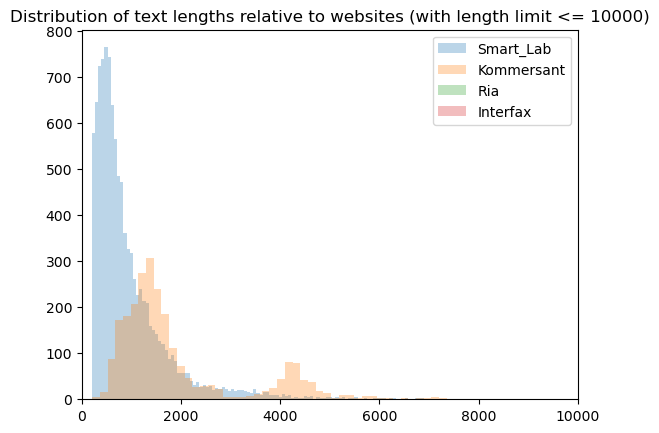

In [33]:
for portal in ['Smart_Lab', 'Kommersant', 'Ria', 'Interfax']:
    plt.hist(df_new[df_new['website']==portal].body_length, bins=400, alpha=0.3, label=portal)

plt.xlim(0, 10000)

plt.title('Distribution of text lengths relative to websites (with length limit <= 10000)')
plt.legend()
plt.show()

> __Conclusions:__ 
> 1. We cleaned the texts from uninformative and unnecessary parts that could harm the quality of our subsequent models 
> 2. After cleaning the news texts, we got rid of practically uninformative and duplicate news 
> 3. You can notice that our distribution of lengths of news texts is determined by the website from which the news was taken, at the moment this does not give us any specific information (except that we have a fairly diverse corpus of texts), but we will keep this in mind when training models later

# Section

> __Reasoning:__ Initially, there was an idea to get rid of news that does not fit our topic based on inappropriate sections, but, as a result, we decided that we will weed out inappropriate news at the entity extraction stage, since the news in this case will be considered inappropriate if does not contain the entity(ies) we need. 
> 
> As a result, at the moment, we decided not to make any transformations based on information about the section from which the news was taken

# Header

In [26]:
df_new[['header']].groupby('header').value_counts().sort_values().tail(354)

header
Для дальнейшего значимого восстановления акций Сбера нужно снижение геополитических рисков - Финам     1
Нефть Brent подешевела до $75,5 за баррель                                                             2
VK приобретает 51% в коммуникационном агентстве Didenok Team                                           2
В Кремле рассказали о ситуации с зерновой сделкой                                                      2
Инфляция во Франции в июне замедлилась до 5,3%                                                         2
                                                                                                      ..
ТОП российских акций средней и малой капитализации: обновление состава - СберИнвестиции                6
Рубль утром стабилен относительно доллара и юаня                                                       6
Цена бензина Аи-95 на российской бирже обновила рекорд                                                 9
В России замедлилась недельная инфляция         

> __Conclusions:__ As you can see, a lot of news has repeating headlines, but these news are not duplicates, since the date of their publication and the text are different, as a result, these are just different news, written according to similar templates under the same headings. We will not get rid of such news

# Date

Processing dates, calculating the number of news items per date

## Interfax

In [27]:
df_interfax = df_new[df_new['website']=='Интерфакс']
df_interfax = df_interfax.reset_index()
df_interfax = df_interfax.drop('index', axis=1)

In [28]:
months = {"января": "1", "февраля": "2", "марта": "3", "апреля": "4", "мая": "5", "июня": "6", "июля":"7", "августа":"8", "сентября":"9", "октября":"10"}


def monthconvert(date):
    for word, initial in months.items():
        date = date.replace(word.lower(), initial)
    return date

In [29]:
def datechanger(date):
    date = monthconvert(date)
    datetime_object = datetime.strptime(date, '%H:%M, %d %m %Y')
    return datetime_object

In [30]:
for i in range(len(df_interfax)):
    df_interfax.loc[i, 'date'] = datechanger(df_interfax.date[i])

In [31]:
df_interfax['datetime'] = df_interfax['date']

In [32]:
dates = []
for i in range(len(df_interfax)):
    dates.append(datetime.date(df_interfax['datetime'][i]))
df_interfax['date'] = dates

In [33]:
weekend = pd.Series()
s = pd.date_range('2023-01-01', '2023-10-24', freq='D').to_series()
for i in s:
    if i.weekday() == 5 or i.weekday() == 6 or i in [datetime(2023, 1, 1), datetime(2023, 1, 2), datetime(2023, 1, 7), datetime(2023, 2, 23),
                                                                    datetime(2023, 3, 8), datetime(2023, 5, 1), datetime(2023, 5, 9),
                                                                    datetime(2023, 6, 12)]:
        weekend[i] = 1
    else:
        weekend[i] = 0

In [34]:
news_by_date = df_interfax.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

In [37]:
def plot_news(source:str):
    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=news_by_date.index, y=weekend,
                             fill = 'tonexty', fillcolor = 'rgba(255, 0, 0, 0.4)',
                             line_shape = 'hv', line_color = 'rgba(0,0,0,0)',
                             showlegend = True, name='Weekends and holidays'
                            ),
                row = 1, col = 1, secondary_y=True)

    fig.add_trace(
        go.Scatter(x = list(news_by_date.index), y=list(news_by_date.values), 
                   line_color='rgba(65,105,225,1)', name='News per day'))

    fig.update_layout(
        title = 'News per day {}'.format(source),
        width=1200,
        height=450,
        xaxis=dict(
            rangeselector=dict(),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show(renderer='png')

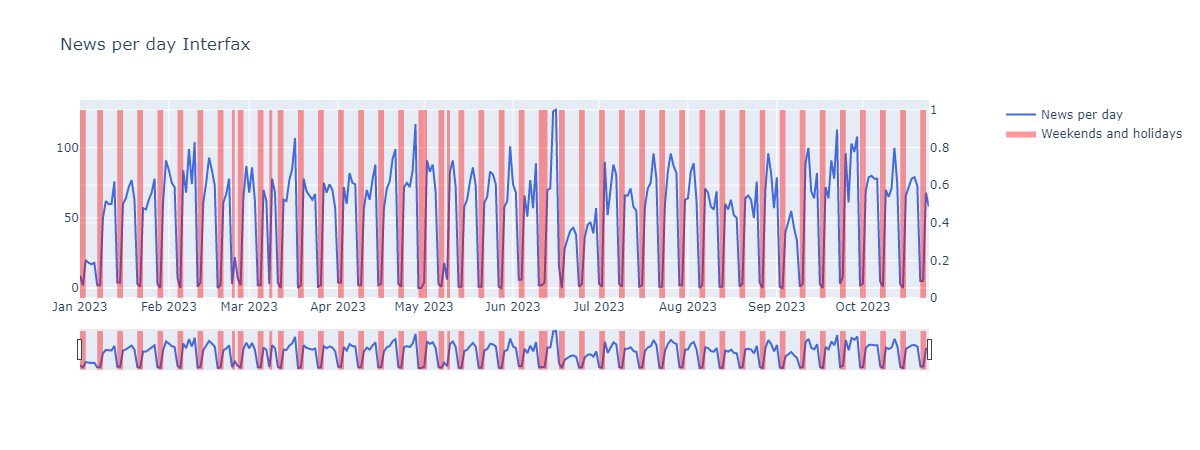

In [38]:
plot_news('Interfax')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items is approximately 75. There is a slight dip in the number of news items at the end of June

## Ria

In [39]:
df_ria = df_new[df_new['website']=='РИА']
df_ria = df_ria.reset_index()
df_ria = df_ria.drop('index', axis=1)

In [40]:
def splitter(str):
    return str.split('\n')

In [41]:
dates_init = []
dates_upd = []
splited = df_ria.date.apply(splitter)
for i in splited:
    dates_init.append(i[0])
    try:
        dates_upd.append(i[1])
    except IndexError:
        dates_upd.append(None)

In [42]:
dates_upd = [i for i in dates_upd if i is not None]
dates_upd = [datetime.strptime(i[12:28], '%H:%M %d.%m.%Y') for i in dates_upd]

In [2]:
df_ria['datetime'] = np.nan
for i in range(len(df_ria)):
    df_ria.loc[i, 'datetime'] = datetime.strptime(dates_init[i], '%H:%M %d.%m.%Y')

In [44]:
dates = []
for i in range(len(df_ria)):
    dates.append(datetime.date(df_ria['datetime'][i]))
df_ria['date'] = dates

In [45]:
news_by_date = df_ria.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

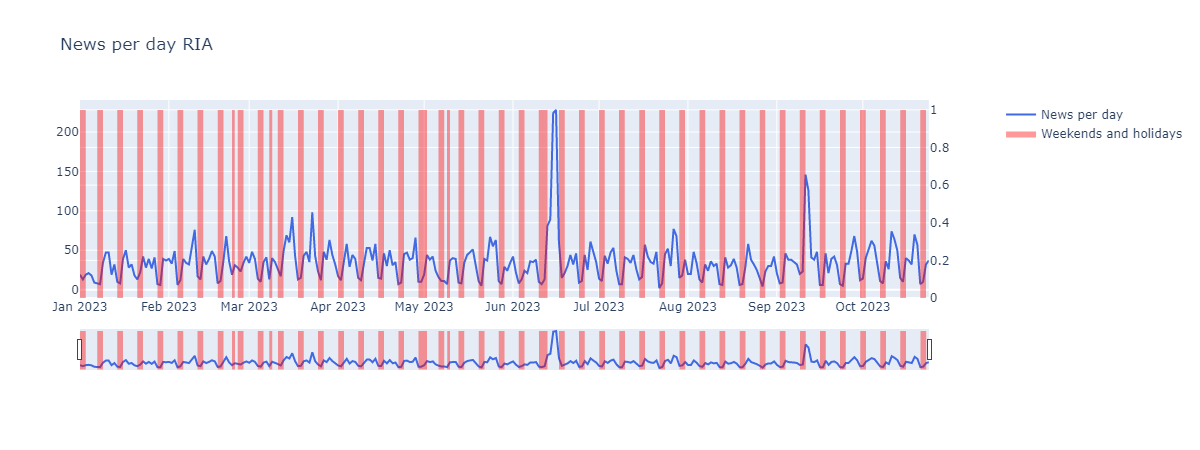

In [46]:
plot_news('RIA')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items is approximately 50. There are very high peaks in June, when the SPIEF took place, and also in September, when the WEF took place

## Smart-lab

In [47]:
df_smart_lab = df_new[df_new['website']=='Smart_Lab']
df_smart_lab = df_smart_lab.reset_index()
df_smart_lab = df_smart_lab.drop('index', axis=1)

In [48]:
def datechanger(date):
    date = monthconvert(date)
    datetime_object = datetime.strptime(date, '%d %m %Y, %H:%M')
    return datetime_object

In [3]:
df_smart_lab['datetime'] = np.zeros(len(df_smart_lab))
for i in range(len(df_smart_lab)):
    df_smart_lab.loc[i, 'datetime'] = datechanger(df_smart_lab['date'][i])

In [50]:
dates = []
for i in range(len(df_smart_lab)):
    dates.append(datetime.date(df_smart_lab['datetime'][i]))
df_smart_lab['date'] = dates

In [51]:
news_by_date = df_smart_lab.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

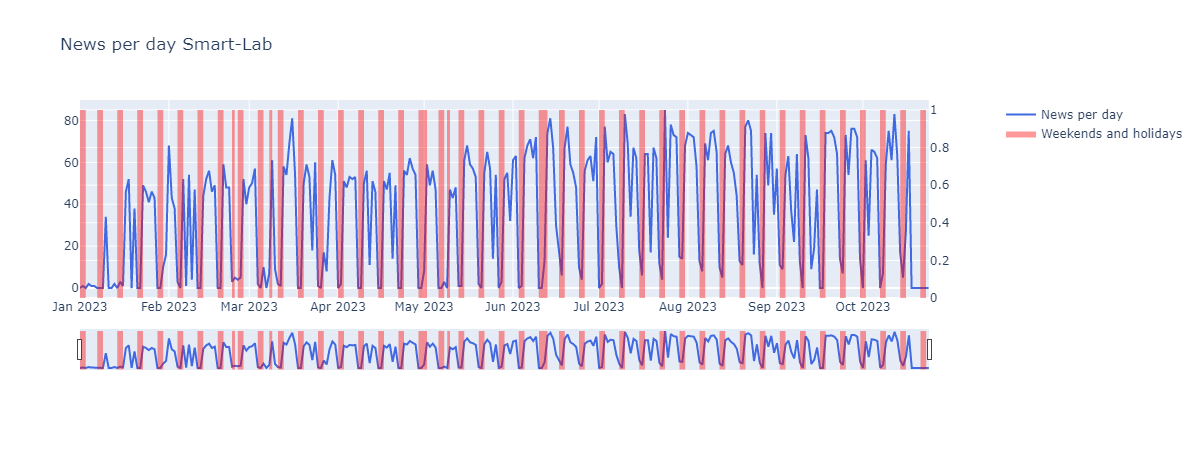

In [52]:
plot_news('Smart-Lab')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items is approximately 70. It deviates from other sources in that there are many other dips in the number of news items. Possible reason: the nature of the portal itself, aggregation of news with lags.

## Kommersant

In [53]:
df_kommersant = df_new[df_new['website']=='Kommersant']
df_kommersant = df_kommersant.reset_index()
df_kommersant = df_kommersant.drop('index', axis=1)

In [54]:
df_kommersant['tags'] = df_kommersant['tags'].replace('[]', np.NaN)

In [4]:
df_kommersant['datetime'] = np.zeros(len(df_kommersant))
for i in range(len(df_kommersant)):
    df_kommersant.loc[i, 'datetime'] = datetime.strptime(df_kommersant['date'][i], '%d.%m.%Y, %H:%M')

In [56]:
dates = []
for i in range(len(df_kommersant)):
    dates.append(datetime.date(df_kommersant['datetime'][i]))
df_kommersant['date'] = dates

In [57]:
news_by_date = df_kommersant.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

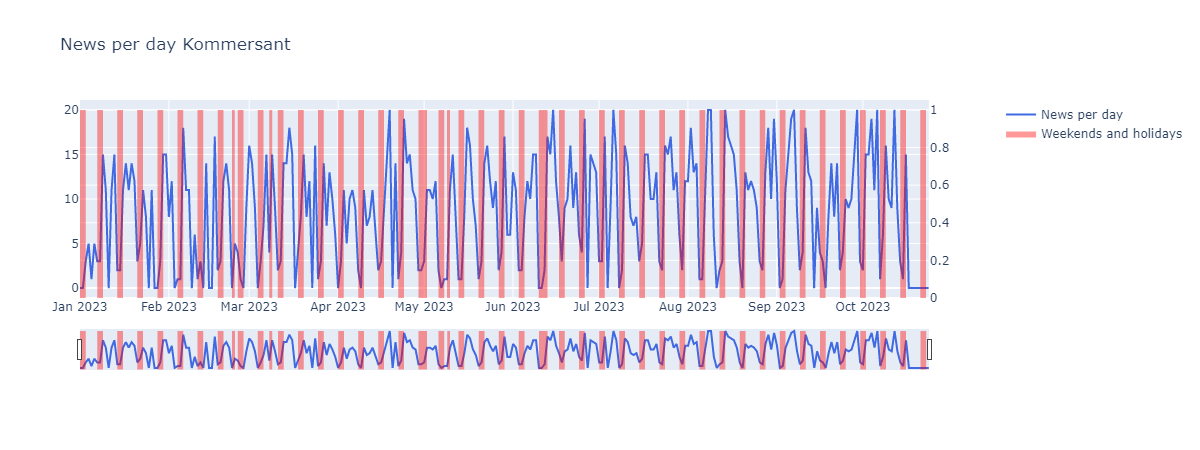

In [58]:
plot_news('Kommersant')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items is approximately 12-13

## Common dataset

In [59]:
df_total = pd.concat(
    [df_interfax, df_ria, df_smart_lab, df_kommersant],
    axis=0,
    ignore_index=True
)

In [60]:
news_by_date = df_total.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

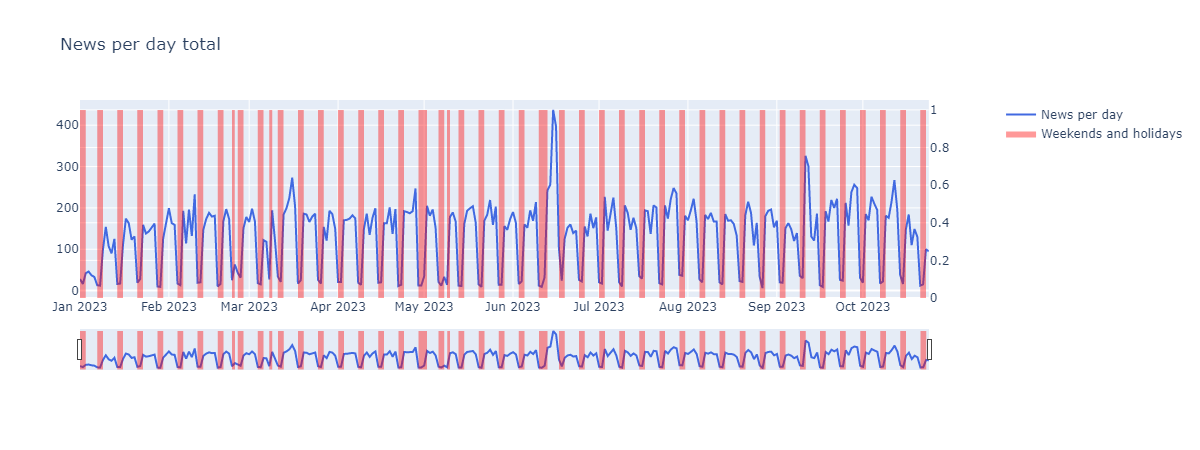

In [61]:
plot_news('total')

> __Intermediate conclusions:__ The general time series looks like a mixture of Interfax and RIA due to the amount of news from these publications. In the overall picture, a decrease in the number of news events even more often coincides with non-working days for the stock exchange

In [62]:
ts_total = df_total.copy()

In [63]:
ts_total.index = ts_total['datetime']

We will leave data only for dates that are available for all publications. 

Let's exclude days on which the exchange was not open. 

Let's limit ourselves to news, the influence of which can be tracked, taking news only in the intervals from 9:30 in the morning to half past 12 in the evening.

In [64]:
ts_total = ts_total[ts_total.index.weekday < 5].between_time('9:30', '23:30')
ts_total = ts_total[~(ts_total['date'].isin(pd.Series([datetime(2023, 1, 1), datetime(2023, 1, 2), datetime(2023, 1, 7), datetime(2023, 2, 23),
                                                                    datetime(2023, 3, 8), datetime(2023, 5, 1), datetime(2023, 5, 9),
                                                                    datetime(2023, 6, 12)]).dt.date.tolist()))]
ts_total = ts_total.sort_index().loc['2023-01-01' : '2023-10-17', :] 

In [65]:
news_by_date = ts_total.groupby('date').date.count()

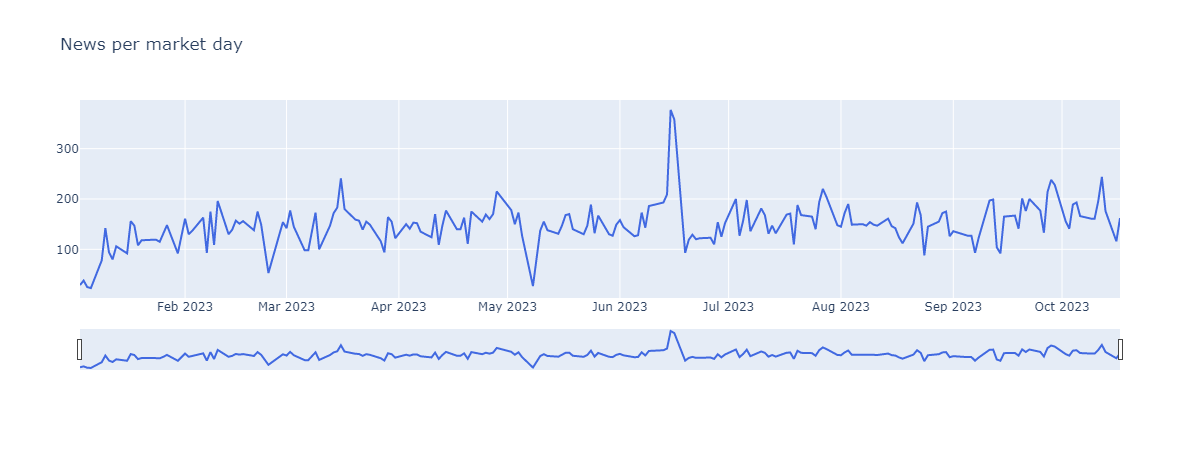

In [76]:
fig = go.Figure()
fig.add_trace(
        go.Scatter(x = list(news_by_date.index), y=list(news_by_date.values), 
                   line_color='rgba(65,105,225,1)', name='News per day', 
                   ))

fig.update_layout(
    title='News per market day',
    width=1200,
    height=450,
    xaxis=dict(
        rangeselector=dict(),
        rangeslider=dict(
            visible=True
        ),
        type="date"
        ))

fig.show('png')

> __Conclusions:__ 
> Based on the time series of news, it can be seen that the number of news fluctuates around the average of approximately 160-170 news per day on days when the Moscow Exchange is open. 
> 
> There are some strong dips associated with weekends according to the general calendar, but the exchange was working on that day, so we did not exclude these dates. This is the beginning of January, February 24 and May 8. 
> 
> There is also a very busy day on June 15th. This is probably due to the SPIEF. 
> 
> In general, the series looks relatively stationary; no seasonality or trends are observed after excluding weekends and holidays.

# Tags

In [67]:
total_tags_key_words = list()
def list_enhancer(a):
    a = a.strip('][').split(', ')
    a = [i.replace("'", '') for i in a]
    a = [i.replace('"', '') for i in a]
    return a


for i in ts_total['tags']:
    if pd.notna(i):
        total_tags_key_words.extend(list_enhancer(i))

<Axes: title={'center': 'News with tags'}, xlabel='tags', ylabel='News'>

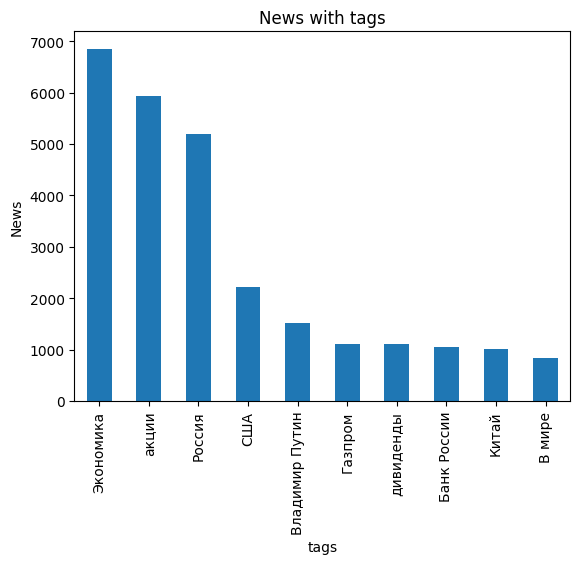

In [68]:
pd.Series(total_tags_key_words).value_counts().head(10).plot(kind='bar', title='News with tags', xlabel='tags', ylabel='News')

In [69]:
pd.Series(total_tags_key_words).value_counts().value_counts()

count
1       8766
2       1787
3        890
4        488
5        327
        ... 
175        1
169        1
166        1
164        1
6848       1
Name: count, Length: 207, dtype: int64

In [70]:
pd.Series(total_tags_key_words).value_counts()

Экономика                            6848
акции                                5940
Россия                               5193
США                                  2226
Владимир Путин                       1515
                                     ... 
Calpers                                 1
Uponor                                  1
Фабрика проектного финансирования       1
Эмираты                                 1
Бренды                                  1
Name: count, Length: 14162, dtype: int64

> __Conclusions:__ 
> Most keywords appear a small number of times: 12,000 tags and keywords appear 1 to 3 times. 
> 
> Most likely, rarely encountered tags will not reflect any entities, but perhaps among them there are synonyms or parts of entities that are reflected by more frequently occurring tags. 
> 
> At the data processing stage, we will try to extract a dictionary of entities. 
> 
> The most common keywords may also not be entities.

# Data export

In [71]:
ts_total.index = pd.RangeIndex(len(ts_total.index))
ts_total = ts_total.drop('date', axis=1)

In [72]:
ts_total

,website,section,url,header,body,tags,body_length,datetime
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,NaN,598,2023-01-03 10:31:00
...,...,...,...,...,...,...,...,...
29894,РИА,Экономика,https://ria.ru/20231017/finansirovanie-1903460...,Финансирование экспорта при санкциях обсудят н...,"Участники сессии ""Финансовый рынок для реаль...","['В России', 'Экономика', 'Россия', 'Форум ""Сд...",2162,2023-10-17 21:05:00
29895,РИА,Экономика,https://ria.ru/20231017/brendy-1903461295.html,Стратегию развития российских брендов обсудят ...,Что Россия может предложить глобальному рынк...,"['В России', 'Экономика', 'Россия', 'Бренды', ...",1551,2023-10-17 21:10:00
29896,РИА,Экономика,https://ria.ru/20231017/deklaratsiya-190346195...,Венгрия и Сербия в декларации назвали действия...,Министр иностранных дел и внешнеэкономически...,"['Сербия', 'Венгрия', 'Болгария', 'Николай Ден...",908,2023-10-17 21:14:00
29897,РИА,Краснодарский край,https://ria.ru/20231017/granty-1903465812.html,Кубань выделила 140 миллионов рублей на гранты...,Власти Краснодарского края выделили из краев...,"['Краснодарский край', 'Экономика', 'Краснодар...",1081,2023-10-17 21:45:00


In [73]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
ts_total.to_sql('clean_data', con=conn, if_exists='replace', index=False) 
conn.close()

In [74]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

df = pd.read_sql_query('SELECT * FROM clean_data', conn)
conn.close()

In [75]:
df

,website,section,url,header,body,tags,body_length,datetime
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00
...,...,...,...,...,...,...,...,...
29894,РИА,Экономика,https://ria.ru/20231017/finansirovanie-1903460...,Финансирование экспорта при санкциях обсудят н...,"Участники сессии ""Финансовый рынок для реаль...","['В России', 'Экономика', 'Россия', 'Форум ""Сд...",2162,2023-10-17 21:05:00
29895,РИА,Экономика,https://ria.ru/20231017/brendy-1903461295.html,Стратегию развития российских брендов обсудят ...,Что Россия может предложить глобальному рынк...,"['В России', 'Экономика', 'Россия', 'Бренды', ...",1551,2023-10-17 21:10:00
29896,РИА,Экономика,https://ria.ru/20231017/deklaratsiya-190346195...,Венгрия и Сербия в декларации назвали действия...,Министр иностранных дел и внешнеэкономически...,"['Сербия', 'Венгрия', 'Болгария', 'Николай Ден...",908,2023-10-17 21:14:00
29897,РИА,Краснодарский край,https://ria.ru/20231017/granty-1903465812.html,Кубань выделила 140 миллионов рублей на гранты...,Власти Краснодарского края выделили из краев...,"['Краснодарский край', 'Экономика', 'Краснодар...",1081,2023-10-17 21:45:00
